In [1]:
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

<img src="https://www.roc.noaa.gov/wsr88d/Images/USACoverageBoB10kFt.png" width="1600">

In [16]:
from datetime import datetime, timedelta
query = rs.query()
now = datetime(2019,4,25,21,0)
now = datetime.now()
query.stations('KAMA').time(now) #datetime.utcnow()

time=2019-05-07T12%3A34%3A48.671090&stn=KAMA

In [17]:
rs.validate_query(query)

True

In [18]:
catalog = rs.get_catalog(query)

In [19]:
catalog.datasets

['KAMA20190507_123327_V06']

In [40]:
station = str(catalog.datasets[0])
station = station[0:4]
station

'KAMA'

In [20]:
ds = list(catalog.datasets.values())[0]
ds.access_urls

{'OPENDAP': 'http://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3/2019/05/07/KAMA/KAMA20190507_123327_V06',
 'HTTPServer': 'http://thredds-aws.unidata.ucar.edu/thredds/fileServer/nexrad/level2/S3/2019/05/07/KAMA/KAMA20190507_123327_V06',
 'CdmRemote': 'http://thredds-aws.unidata.ucar.edu/thredds/cdmremote/nexrad/level2/S3/2019/05/07/KAMA/KAMA20190507_123327_V06'}

In [21]:
from siphon.cdmr import Dataset
data = Dataset(ds.access_urls['CdmRemote'])

In [22]:
print(data.time_coverage_start)
time_stamp = data.time_coverage_start[:10].replace("-","_")+"_"+data.time_coverage_start[11:16].replace(":","")+"Z"
time_stamp

2019-05-07T12:33:27Z


'2019_05_07_1233Z'

In [23]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [24]:
sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

In [25]:
ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

In [26]:
from metpy.plots import ctables  # For NWS colortable
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

/Users/chowdahead/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [27]:
import matplotlib.pyplot as plt
import cartopy

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = cartopy.crs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    # Grab state borders
    state_borders = cartopy.feature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    plt.savefig("/Users/chowdahead/Desktop/RADAR_"+time_stamp+".png")
    return ax

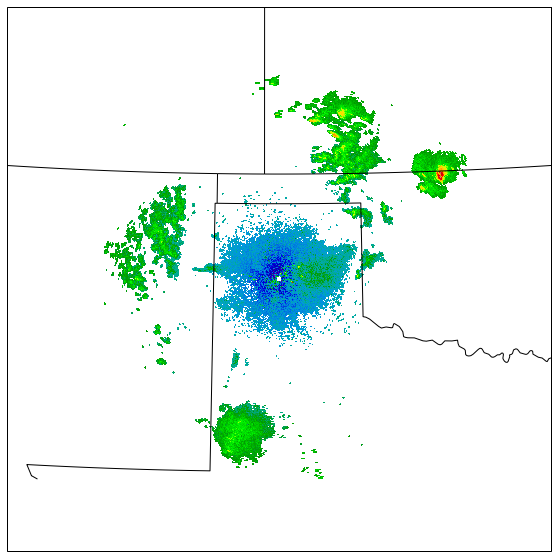

In [28]:
fig = plt.figure(figsize=(10, 10))
 # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
proj = cartopy.crs.LambertConformal(central_longitude=data.StationLongitude, central_latitude=data.StationLatitude)

    # New axes with the specified projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines
ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    # Grab state borders
state_borders = cartopy.feature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
#ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
ax.pcolormesh(x, y, ref, cmap='nipy_spectral', zorder=0)

plt.savefig("/Users/chowdahead/Desktop/RADAR_"+time_stamp+".png",bbox_inches="tight")
#ax = new_map(fig, data.StationLongitude, data.StationLatitude)
#ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

In [28]:
query = rs.query()
dt = datetime(2019, 4, 25, 17) # Our specified time
query.lonlat_point(-73.687, 41.175).time_range(dt, dt + timedelta(hours=1))

time_start=2019-04-25T17%3A00%3A00&time_end=2019-04-25T18%3A00%3A00&longitude=-73.687&latitude=41.175

In [29]:
cat = rs.get_catalog(query)
cat.datasets

['KOKX20190425_170152_V06', 'KOKX20190425_171022_V06', 'KOKX20190425_171852_V06', 'KOKX20190425_172722_V06', 'KOKX20190425_173546_V06', 'KOKX20190425_174410_V06', 'KOKX20190425_175234_V06']

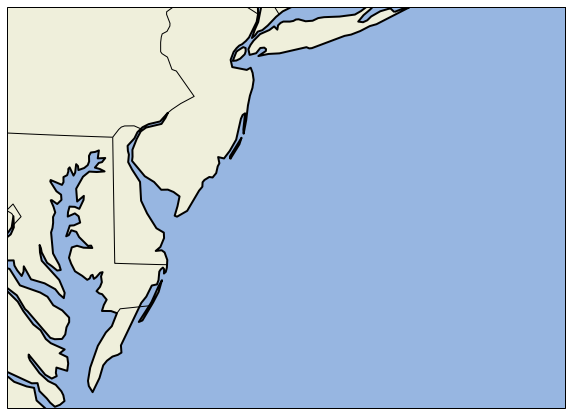

In [58]:
ds = list(cat.datasets.values())[0]
data = Dataset(ds.access_urls['CdmRemote'])
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)

# Set limits in lat/lon space
ax.set_extent([-77, -70, 37, 41])

# Add ocean and land background
ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', scale='50m',
                                            edgecolor='face',
                                            facecolor=cartopy.feature.COLORS['water'])
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='50m',
                                           edgecolor='face',
                                           facecolor=cartopy.feature.COLORS['land'])

ax.add_feature(ocean, zorder=-1)
ax.add_feature(land, zorder=-1)

In [59]:
meshes = []
for item in sorted(cat.datasets.items()):
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    ds = item[1]
    data = Dataset(ds.access_urls['CdmRemote'])

    # Pull out the data of interest
    sweep = 0
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref_var = data.variables['Reflectivity_HI']

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.65, 0.03, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))

In [60]:
# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [61]:
import matplotlib.animation as manimation; manimation.writers.list()

['pillow', 'html']

In [64]:
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [30]:
import matplotlib.pyplot as plt
import matplotlib
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
from metpy.plots import ctables  # For NWS colortable

2019-05-07T15:58:52Z
2019-05-07T16:05:51Z
2019-05-07T16:09:21Z
2019-05-07T16:16:19Z
2019-05-07T16:19:50Z
2019-05-07T16:23:20Z
2019-05-07T16:30:23Z
2019-05-07T16:33:54Z
2019-05-07T16:41:02Z
2019-05-07T16:44:20Z
2019-05-07T16:50:54Z
2019-05-07T16:54:11Z
done.


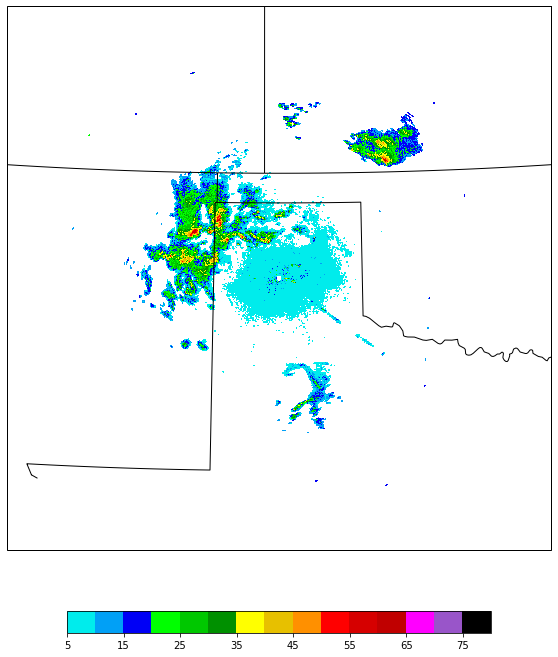

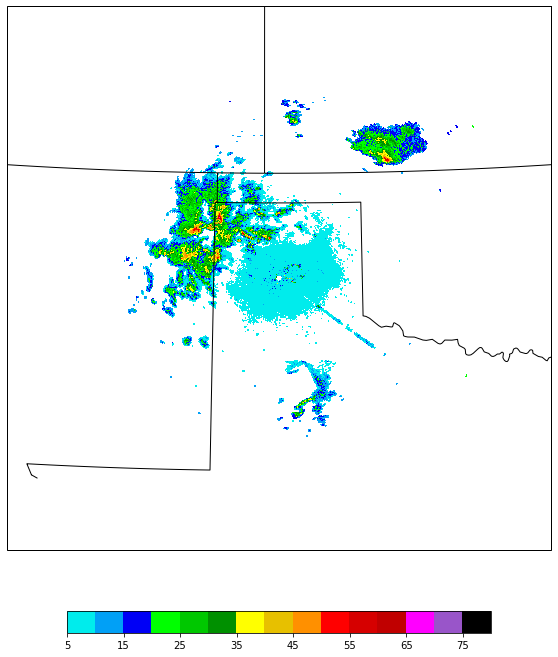

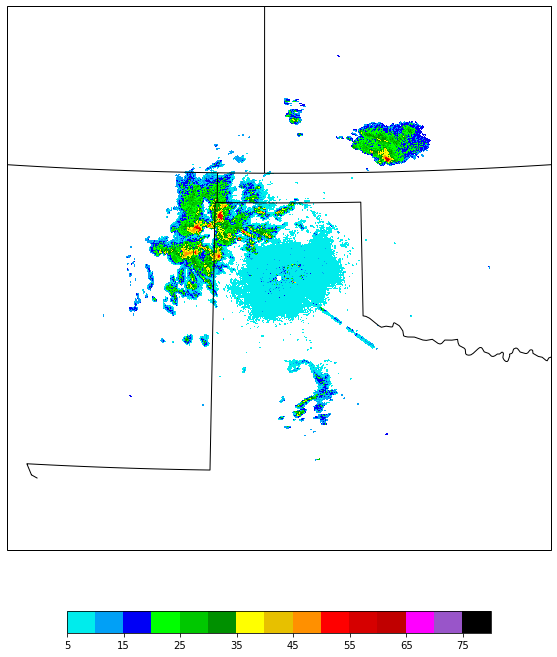

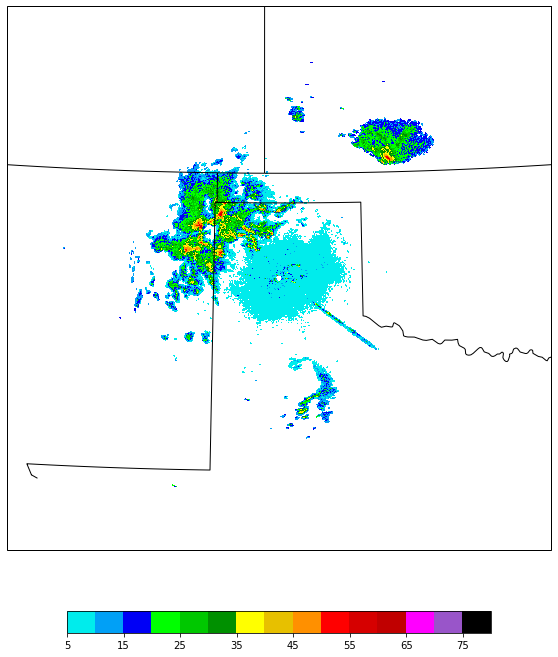

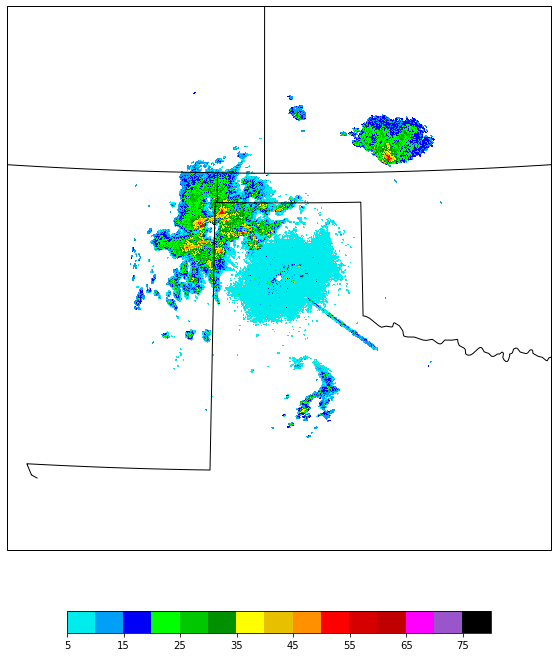

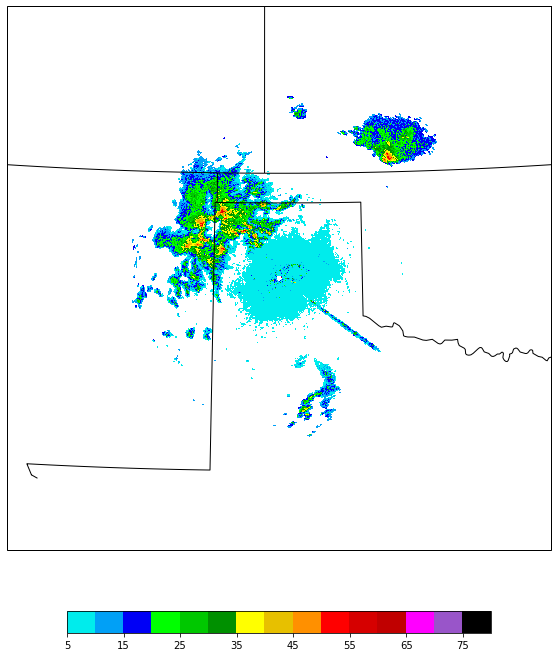

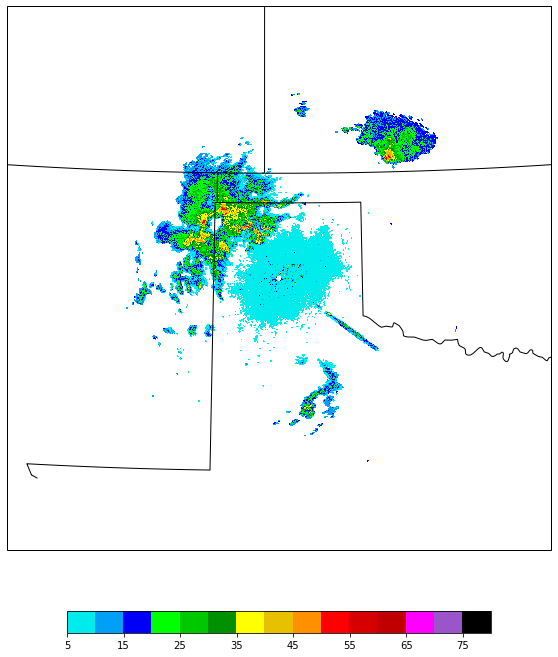

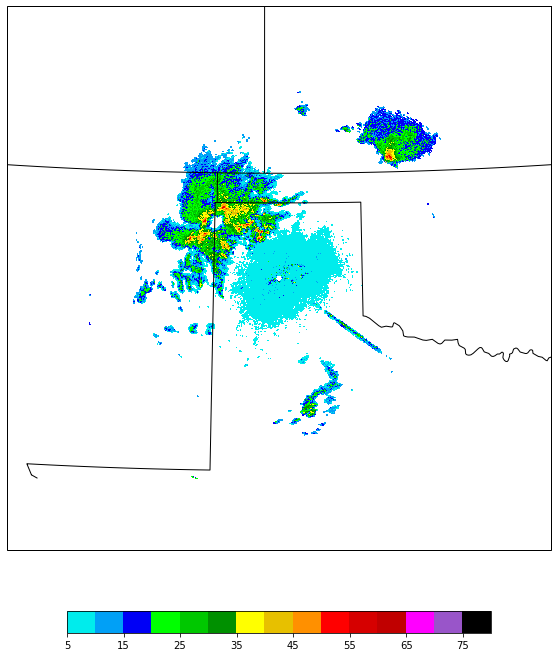

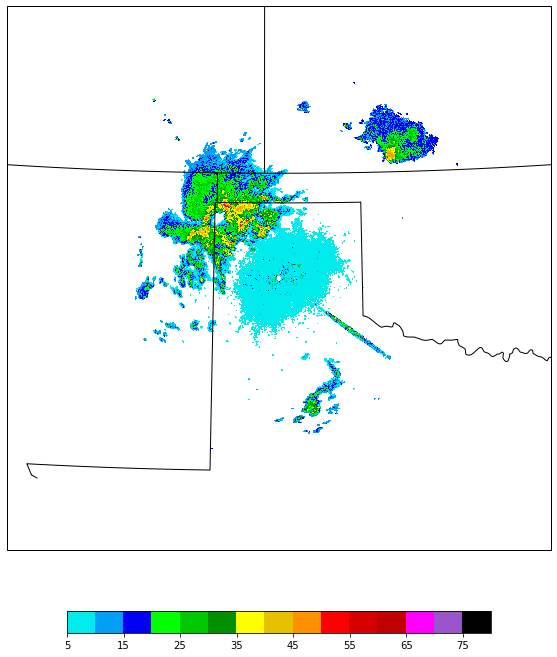

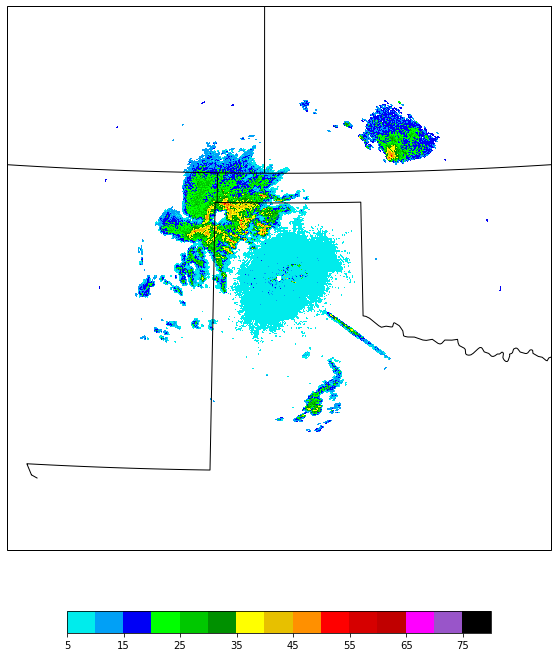

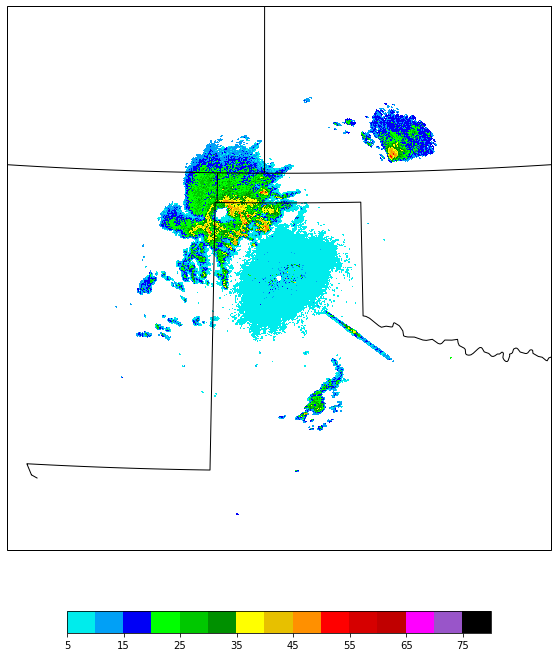

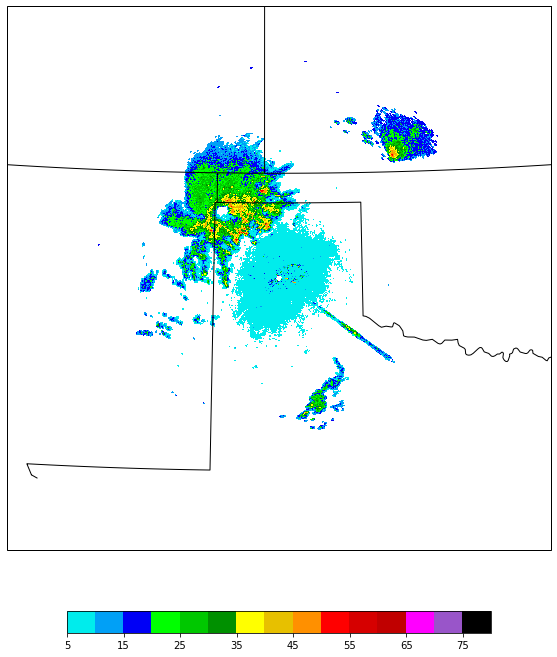

In [30]:
for i in range(12):    
    query = rs.query()
    now = datetime(2019,5,7,16,i*5)
    query.stations('KAMA').time(now) #datetime.utcnow()
    rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

    rs.validate_query(query)
    catalog = rs.get_catalog(query)
    catalog.datasets
    ds = list(catalog.datasets.values())[0]
    ds.access_urls
    data = Dataset(ds.access_urls['CdmRemote'])
    print(data.time_coverage_start)
    time_stamp = data.time_coverage_start[:10].replace("-","_")+"_"+data.time_coverage_start[11:16].replace(":","")+"Z"
    time_stamp
    sweep = 0
    ref_var = data.variables['Reflectivity_HI']
    ref_data = ref_var[sweep]
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref = raw_to_masked_float(ref_var, ref_data)
    x, y = polar_to_cartesian(az, rng)
    ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

    fig = plt.figure(figsize=(10, 10))
     # Create projection centered on the radar. This allows us to use x
        # and y relative to the radar.
    proj = cartopy.crs.LambertConformal(central_longitude=data.StationLongitude, central_latitude=data.StationLatitude)

        # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

        # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

        # Grab state borders
    state_borders = cartopy.feature.NaturalEarthFeature(
            category='cultural', name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    radar = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    
    # Colorbar Axis Placement (under figure)
    colorbar_axis = [0.218, 0.01, 0.589, 0.03] # [left, bottom, width, height]

    cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]

    cbar = plt.colorbar(radar, orientation='horizontal',cax=cbaxes)
    plt.savefig("/Users/chowdahead/Desktop/"+station+"RADAR_"+time_stamp+".png",bbox_inches="tight")
    #ax = new_map(fig, data.StationLongitude, data.StationLatitude)
    #ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
print("done.")

2019-04-04T01:01:40Z
2019-04-04T01:06:46Z
2019-04-04T01:11:53Z
2019-04-04T01:16:59Z
2019-04-04T01:21:59Z
2019-04-04T01:26:58Z
2019-04-04T01:31:57Z
2019-04-04T01:36:58Z
2019-04-04T01:42:27Z
2019-04-04T01:42:27Z
2019-04-04T01:47:41Z
2019-04-04T01:53:11Z


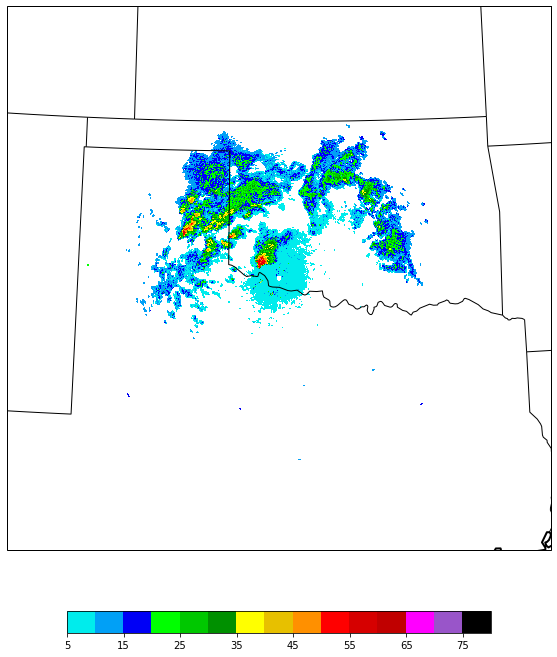

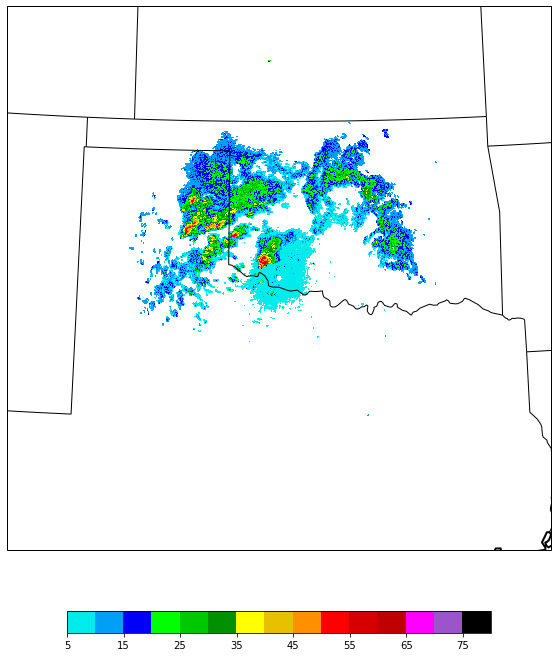

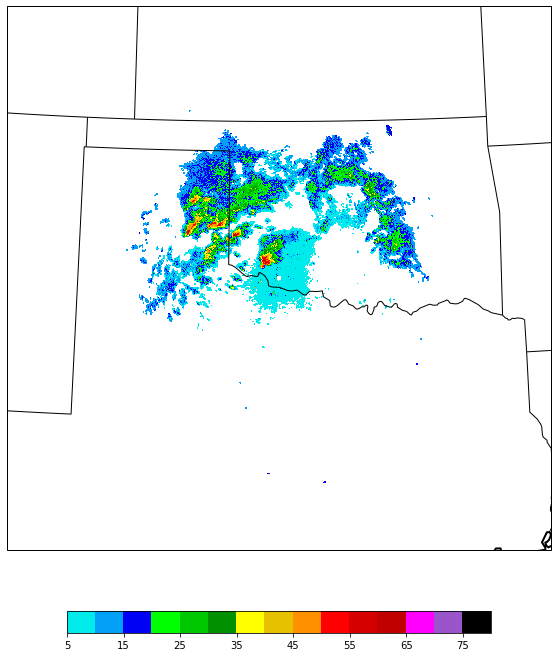

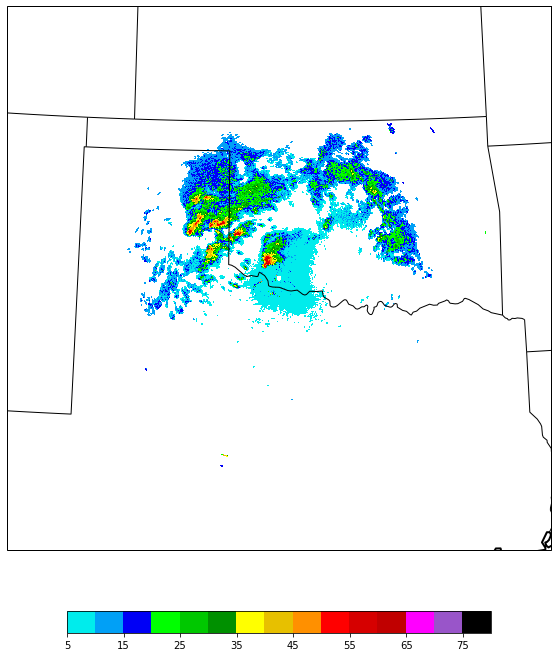

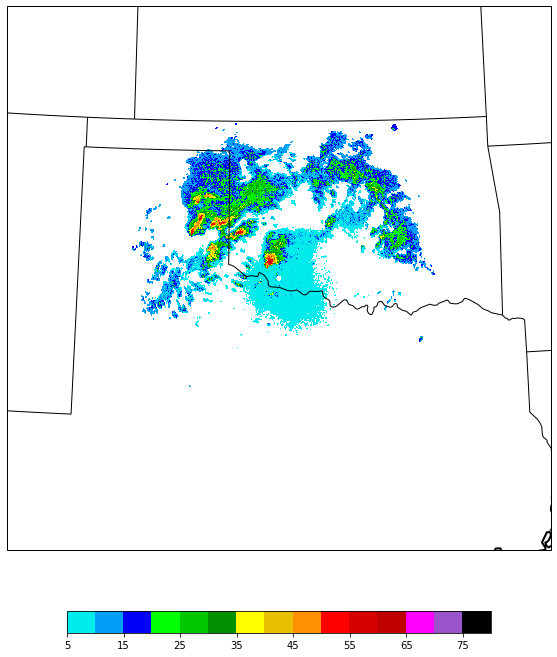

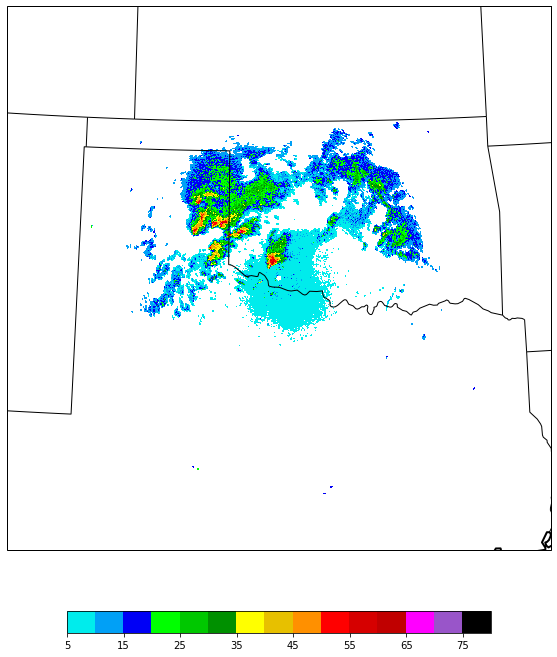

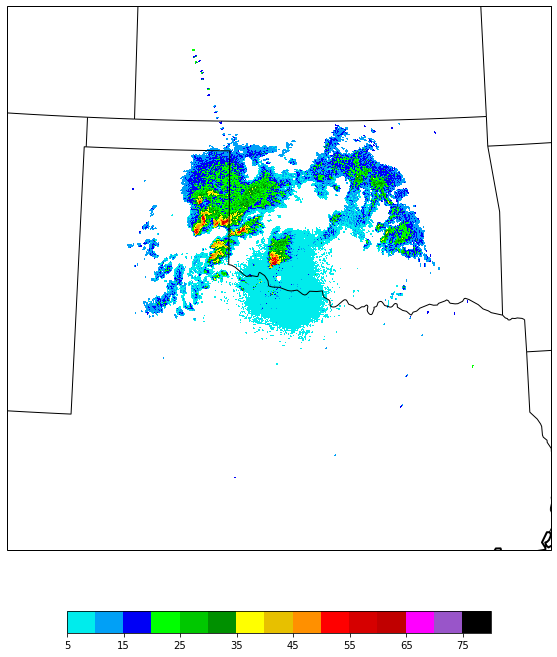

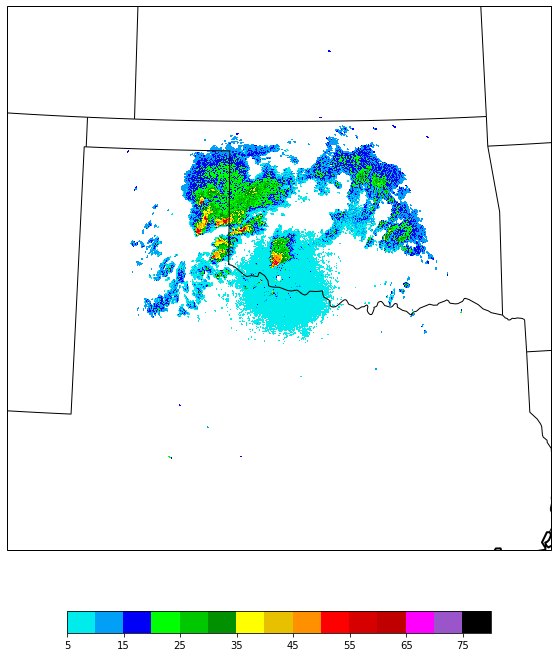

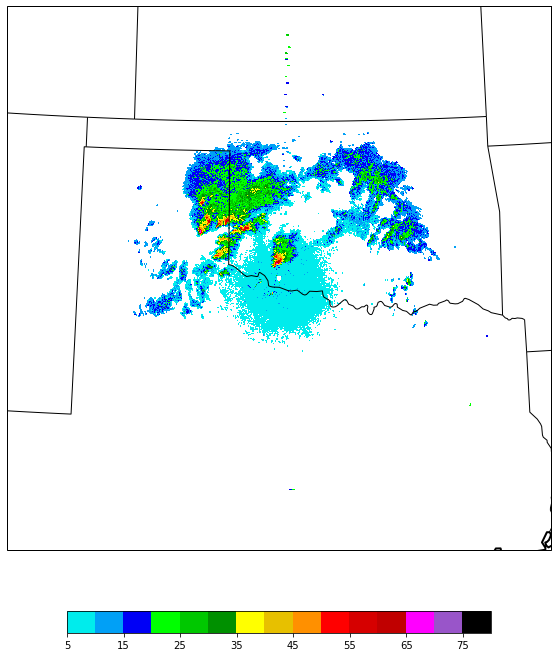

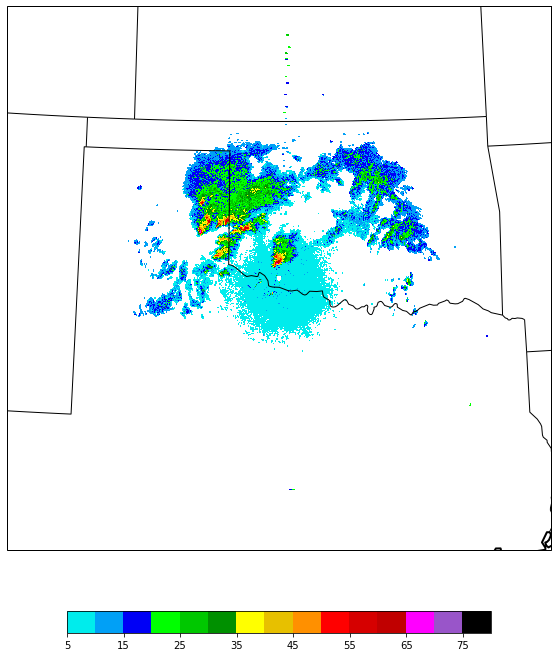

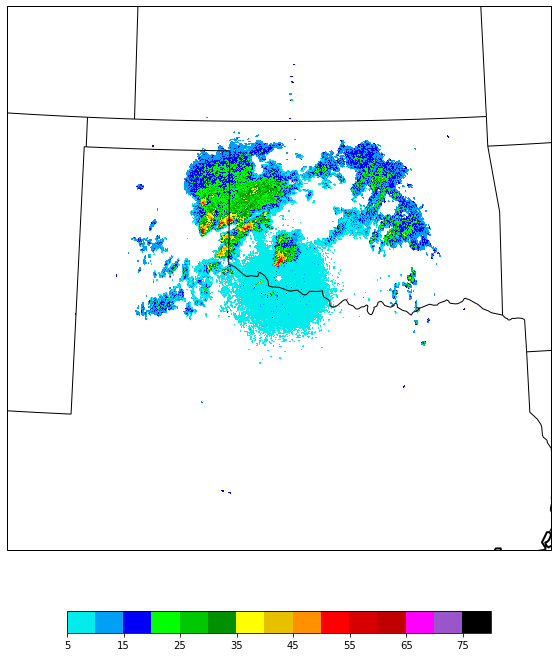

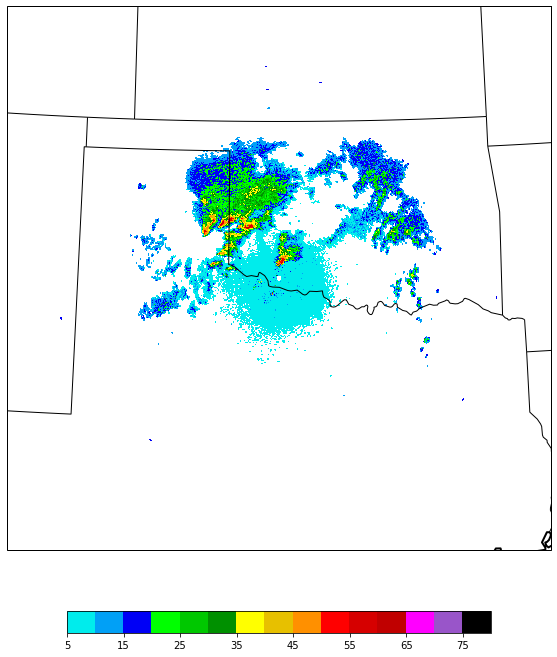

In [12]:
for i in range(12):    
    query = rs.query()
    now = datetime(2019,4,4,1,i*5)
    query.stations('KFDR').time(now) #datetime.utcnow()
    rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

    rs.validate_query(query)
    catalog = rs.get_catalog(query)
    catalog.datasets
    ds = list(catalog.datasets.values())[0]
    ds.access_urls
    data = Dataset(ds.access_urls['CdmRemote'])
    print(data.time_coverage_start)
    time_stamp = data.time_coverage_start[:10].replace("-","_")+"_"+data.time_coverage_start[11:16].replace(":","")+"Z"
    time_stamp
    sweep = 0
    ref_var = data.variables['Reflectivity_HI']
    ref_data = ref_var[sweep]
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref = raw_to_masked_float(ref_var, ref_data)
    x, y = polar_to_cartesian(az, rng)
    ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

    fig = plt.figure(figsize=(10, 10))
     # Create projection centered on the radar. This allows us to use x
        # and y relative to the radar.
    proj = cartopy.crs.LambertConformal(central_longitude=data.StationLongitude, central_latitude=data.StationLatitude)

        # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

        # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

        # Grab state borders
    state_borders = cartopy.feature.NaturalEarthFeature(
            category='cultural', name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    radar = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    # Colorbar Axis Placement (under figure)
    colorbar_axis = [0.218, 0.01, 0.589, 0.03] # [left, bottom, width, height]

    cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]

    cbar = plt.colorbar(radar, orientation='horizontal',cax=cbaxes)
    plt.savefig("/Users/chowdahead/Desktop/KFDR_"+time_stamp+".png",bbox_inches="tight")
    #ax = new_map(fig, data.StationLongitude, data.StationLatitude)
    #ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

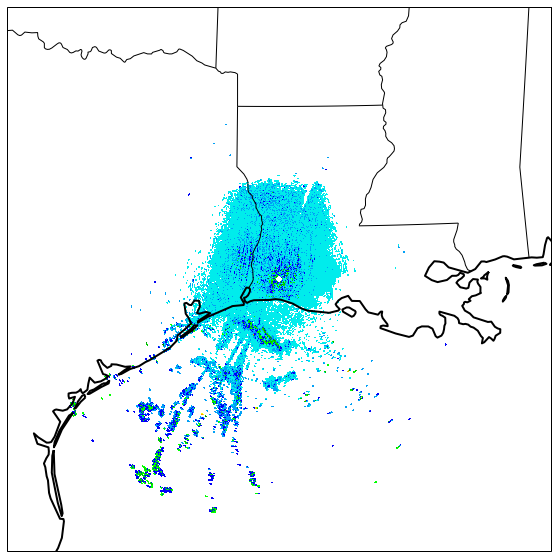

In [28]:
fig = plt.figure(figsize=(10, 10))
 # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
proj = cartopy.crs.LambertConformal(central_longitude=data.StationLongitude, central_latitude=data.StationLatitude)
    # New axes with the specified projection
ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines
ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    # Grab state borders
state_borders = cartopy.feature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
plt.savefig("/Users/chowdahead/Desktop/RADAR_"+time_stamp+".png",bbox_inches="tight")
#ax = new_map(fig, data.StationLongitude, data.StationLatitude)
#ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

In [24]:
ctables.registry.get_with_steps?